In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
"""
이미지 불러오기
"""

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
                                                        # 본인이 선택한 이미지 경로
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(871, 1086, 3)


<br>

## 세그멘테이션 모델 생성 : DeepLab 모델 <br>

DeepLab 모델을 준비하겠습니다. 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다. <br><br>

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다. 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리 합니다. 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다. 전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것을 볼 수 있습니다. <br><br>

>
AIFFEL의 딥러닝 관련 코드는 Tensorflow V2 기준으로 작성되지만, 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델구조를 그대로 가져와 활용하면서, Tensorflow V2에서 V1 코드와 모델구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용하고 있습니다. 그래서 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있습니다.
Tensorflow V1에서 작성된 수많은 레거시 코드들을 활용하려면 어떻게 해야 하는지를 학습하는 의미에서 Tensorflow V2 코드와 비교해 가면서 보기를 바랍니다.
>

<br>

In [4]:
"""
DeepLab 모델 
구글에서 제공하는 모델 구조를 그대로 가져와 DeepLabModel 클래스 생성
"""

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, 
    # tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

<br>

### 사전 학습된 가중치 불러오기 <br>

위 DeepLab으로 이미 학습하여 가중치를 다 변경해 놓아 사전에 학습된 가중치(pretrained weight)를 갖고 있는 모델을 불러옵니다. 구글에서 제공하는 파일을 다운로드 하겠습니다. ( 오래 걸릴 수 있습니다 ) <br><br>

구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고 DeepLabModel 을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다. <br>

>
다양한 데이터셋과 백본(backbone) 모델에 대한 pretrained weight은 [여기](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md)에서 확인할 수 있습니다.
>

<br>

In [5]:
"""
PASCAL VOC 2012 데이터셋으로 사전 학습된 모델 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고, 
DeepLabModel 을 초기화
"""

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac29/aiffel/human_segmentation/models
model loaded successfully!


<br>

## 모델 사용 <br>

(내 경우)
input 이미지로 들어간 나의 사진 크기는 871*1086 이고, <br>
resize 되어 출력된 나의 사진 크기는 411*513 이 되었습니다. <br>
( 참고. OpoenCV는 채널을 HWC 순서로 표시하는 점 주의 ) <br><br>

seg_map.max() 는 20 이라는 값이 출력됩니다. <br>
세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻합니다. <br>
이 값이 20라는 것은 무슨 의미일까요?

<br>

In [6]:
"""
첫 단계 : 준비한 이미지를 네트워크에 입력
"""

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(871, 1086, 3) (411, 513, 3) 15


<br>

### 모델에 학습된 데이터 확인

위에서 말씀드린 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. <br>
우리가 사용한 사전학습된 모델이 학습하는데 어떤 데이터를 사용하여 어떤 결과를 출력했는지 확인해 봅시다. <br><br>

background를 제외하면 20개의 클래스가 있습니다. <br>
따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요. <br>
우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다.

<br>

In [7]:
"""
우리가 사용한 사전학습된 DeepLab 모델의 학습에 사용되었던 데이터
PASCAL VOC 의 라벨(label) 확인
"""

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

<br>

## 결과 시각화 <br>

1. 사람(person) 라벨에 해당하는 15를 갖는 영역을 제외한 나머지는 0으로 만들어 마스크를 만듭니다. <br>
2. 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. <br>
( 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로 )
3. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

<br>

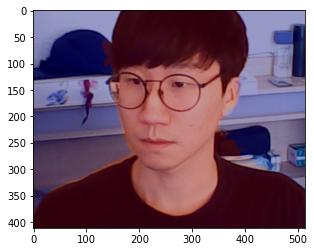

In [8]:
"""
원하는 레이블 영역만 마스킹 후, 
matplotlib 으로 이미지 출력
"""

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

<br>

### 이미지 사이즈 복원 <br>

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. <br>
따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다. <br><br>

세그멘테이션 결과(mask)를 원래 크기로 복원해야 합니다. <br><br>

>
cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 합니다. <br>
cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. <br><br>
여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다. 자세한 사항은 [opencv-python 문서](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html)를 참고할 수 있습니다. <br><br>
결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.
>

<br>

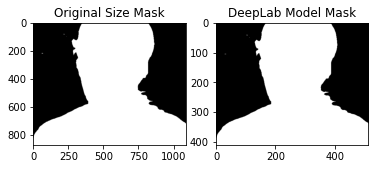

In [9]:
"""
DeepLab 모델 학습 과정에서 resize 하여 출력된 segmentation mask 결과를 원본 이미지 size 크기로 복원
OpenCV 의 보간법(interpolation) 처리 사용
"""

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

<br>

## 배경 블러처리 <br>

세그멘테이션 마스크를 이용해 배경만 추출합니다. <br>

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 되겠죠? <br>
반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. <br>

참고 : [StackOverflow: bitwise_not, bitwise_and 함수를 사용해 이미지 바꾸기](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)

<br>

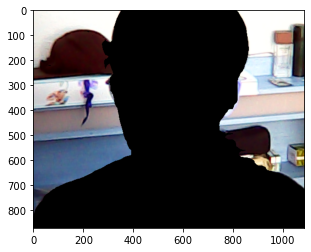

In [10]:
"""
세그멘테이션 마스크 이용해 배경만 추출 후
OpenCV의 bitwise_not 함수로 이미지 반전
"""

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

<br>

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 되겠죠? <br>
반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. <br>

참고 : [StackOverflow: bitwise_not, bitwise_and 함수를 사용해 이미지 바꾸기](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)

<br>

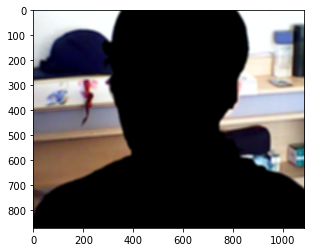

In [11]:
"""
배경에 해당하는 마스크된 이미지
OpenCV 의 .blur() 함수로 블러처리
"""

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

<br>

## 쨘 ! <br>

마스킹한 사람 이미지와 마스킹 반전 후 블러처리한 배경 이미지를 합치면, 쨘 ! <br><br>

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다. <br>
참고 : [numpy.where() 사용법](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

<br>

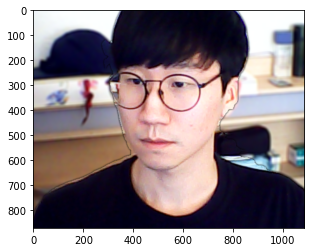

In [12]:
"""
numpy 로 마스킹으로 분리된 사람과 배경 두 이미지 픽셀데이터 병합하여 이미지 합치기
"""

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

<br>

## 고양이 사진 Segmentation

<br>

In [13]:
"""
이미지 불러오기
"""

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cats.jpg'  
                                                        # 본인이 선택한 이미지 경로
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1078, 1078, 3)


In [14]:
"""
첫 단계 : 준비한 이미지를 네트워크에 입력
"""

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1078, 1078, 3) (513, 513, 3) 8


In [15]:
"""
우리가 사용한 사전학습된 DeepLab 모델의 학습에 사용되었던 데이터
PASCAL VOC 의 라벨(label) 확인
"""

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

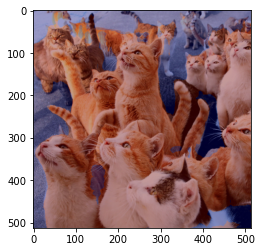

In [16]:
"""
원하는 레이블 영역만 마스킹 후, 
matplotlib 으로 이미지 출력
"""

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

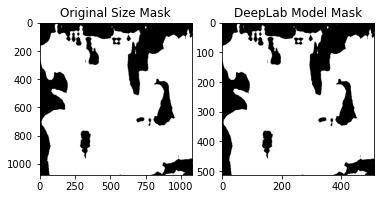

In [17]:
"""
DeepLab 모델 학습 과정에서 resize 하여 출력된 segmentation mask 결과를 원본 이미지 size 크기로 복원
OpenCV 의 보간법(interpolation) 처리 사용
"""

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

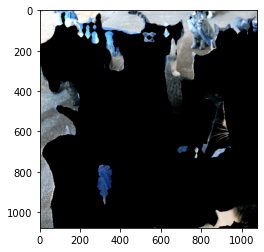

In [18]:
"""
세그멘테이션 마스크 이용해 배경만 추출 후
OpenCV의 bitwise_not 함수로 이미지 반전
"""

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

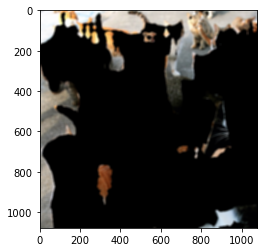

In [19]:
"""
배경에 해당하는 마스크된 이미지
OpenCV 의 .blur() 함수로 블러처리
"""

img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

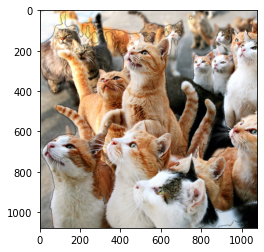

In [20]:
"""
numpy 로 마스킹으로 분리된 사람과 배경 두 이미지 픽셀데이터 병합하여 이미지 합치기
"""

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

<br>

## 크로마키 배경합성

<br>

In [64]:
"""
이미지 불러오기
"""

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
                                                        # 본인이 선택한 이미지 경로
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(871, 1086, 3)


In [65]:
"""
첫 단계 : 준비한 이미지를 네트워크에 입력
"""

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(871, 1086, 3) (411, 513, 3) 15


In [66]:
"""
우리가 사용한 사전학습된 DeepLab 모델의 학습에 사용되었던 데이터
PASCAL VOC 의 라벨(label) 확인
"""

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

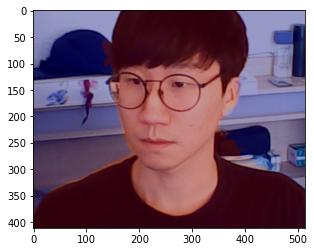

In [67]:
"""
원하는 레이블 영역만 마스킹 후, 
matplotlib 으로 이미지 출력
"""

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

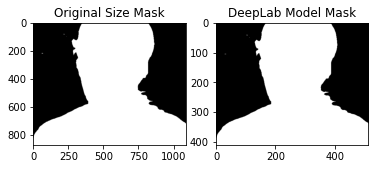

In [68]:
"""
DeepLab 모델 학습 과정에서 resize 하여 출력된 segmentation mask 결과를 원본 이미지 size 크기로 복원
OpenCV 의 보간법(interpolation) 처리 사용
"""

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

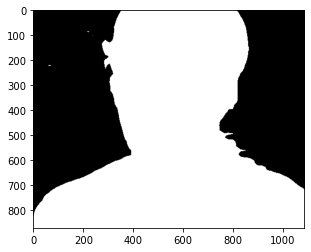

In [69]:
"""
세그멘테이션 마스크 이용해 배경만 추출
"""

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
plt.imshow(img_mask_color)
plt.show()

In [70]:
"""
배경 이미지 불러오기
"""

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/art.jpg'  
                                                        # 본인이 선택한 이미지 경로
img_art = cv2.imread(img_path) 
print (img_art.shape)

(1181, 1181, 3)


In [71]:
"""
배경 이미지 크기 원본 이미지와 같게 resize
"""

img_art_resized = cv2.resize(img_art, dsize=(1086, 871), interpolation=cv2.INTER_AREA)
print (img_art_resized.shape)

(871, 1086, 3)


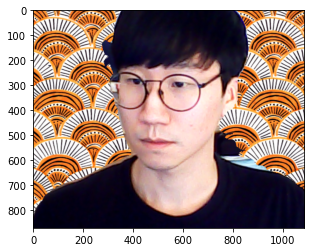

In [74]:
"""
배경에 해당하는 마스크된 이미지
OpenCV 의 .copyTo() 함수로 다른 이미지 적용
배경영역 마스킹 img_mask_color 사용
"""

img_bg_art = cv2.copyTo(img_orig, img_mask_color, img_art_resized)
plt.imshow(cv2.cvtColor(img_bg_art, cv2.COLOR_BGR2RGB))
plt.show()

<br>

## 문제점

1. 객체 주변의 배경이 객체영역에 포함되거나, 객체 영역이 배경에 포함되는 경우가 있습니다. <br>
( 두번째 사진의 마스킹을 보면, 고양이 일부가 배경으로 안 잡힌 경우가 있음 ) <br>
2. 객체가 여러개 겹쳐있을 경우, 멀리 있는 객체도 같이 포커싱 되어 부자연스러울 수 있습니다. <br>
( 두번째 고양이들 사진을 보면 원경의 고양이가 블러처리되지 않음 ) <br>
3. 고양이같이 털이 있는 동물객체의 경우 경계가 뚜렷하여 부자연스러울 수 있습니다. <br>
( 두번째 배경합성 사진을 보면 고양이 외곽이 너무 반듯하게 잘려있음 )

<br>

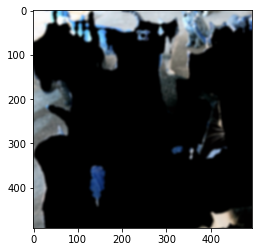

In [77]:
"""
문제의 마스킹 이미지
"""

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/error.png'  
                                                        # 본인이 선택한 이미지 경로
img_error = cv2.imread(img_path) 
plt.imshow(img_error)
plt.show()

<br>

## 해결방안 <br><br>


### 1번 문제의 해결안 <br><br>

1. Lidar 센서가 함께 달린 카메라로 촬영한 이미지를 사용
2. 이미지의 rgb 데이터에 Lidar의 depth 정보를 추가하여 segmentation 을 학습
( Lidar 정보가 pixel 데이터 크기와 맞지 않을 경우 보간 방법 등을 사용하여 맞추어 줍니다 )
3. depth 정보가 포함된 학습결과를 통해, 원경과 근경사이 물체를 더 정밀하게 분류해낼 수 있습니다. <br><br>


### 2번 문제의 해결안 <br><br>

1. Instance Segmentation 의 사용
2. Semantic Segmentation 과 Instance Segmentation 을 함께 사용하여, 객체를 따로따로 분류
3. 포커스를 맞출 객체로부터 멀리 떨어진 객체에 대해 차등적 blur 적용 <br><br>


### 3번 문제의 해결안 <br><br>

1. 동물류의 class에 대해 blur 의 경계옵션을 부드럽게 바꾸어 주는 함수를 생성하여 적용해 줍니다.

<br>